In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print( device )

cuda


In [ ]:
path = os.path.expanduser( '~/SimCLR/runs/Apr13_14-18-24_j-leelab1.mae.ncsu.edu/checkpoint_0200.pth.tar' )
checkpoint = torch.load(path, map_location=device)
state_dict = checkpoint['state_dict']

# Model: ResNet18 !
model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)
model.eval()

/home/hjang4/anaconda3/envs/simclr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hjang4/anaconda3/envs/simclr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Eliminate lase fc layer ... feature extractor, f(.)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

dataset_path = os.path.expanduser( '~/SimCLR/datasets' )
stl10_test = torchvision.datasets.STL10(root=dataset_path, split='test', download=False, transform=transforms.ToTensor())

# 10 samples with different labels from STL10 test dataset
unique_indices = {}
for idx in range(len(stl10_test)):
    # stl10_test[idx] returns (image, label)
    _, label = stl10_test[idx]
    if label not in unique_indices:
        unique_indices[label] = idx
    if len(unique_indices) == 10: 
        break
indices = [unique_indices[label] for label in sorted(unique_indices.keys())]
subset = torch.utils.data.Subset(stl10_test, indices)
subset_loader = torch.utils.data.DataLoader(subset, batch_size=10, shuffle=False)

images, labels = next(iter(subset_loader))
images = images.to(device)
print(indices)

[3, 5, 24, 4, 8, 2, 0, 1, 55, 17]


In [26]:
# Representation vector calculated from feature_extractor, ResNet18 (avgpool + flatten)
with torch.no_grad():
    features = feature_extractor(images)  # shape: (batch, feature_dim, 1, 1)
    features = features.view(features.size(0), -1)  # shape: (batch, feature_dim)

# L2 norm
features_norm = features / features.norm(dim=1, keepdim=True)

# cosine similarity matrix
cosine_sim_model = features_norm @ features_norm.t()
cosine_sim_model = cosine_sim_model.cpu().numpy()

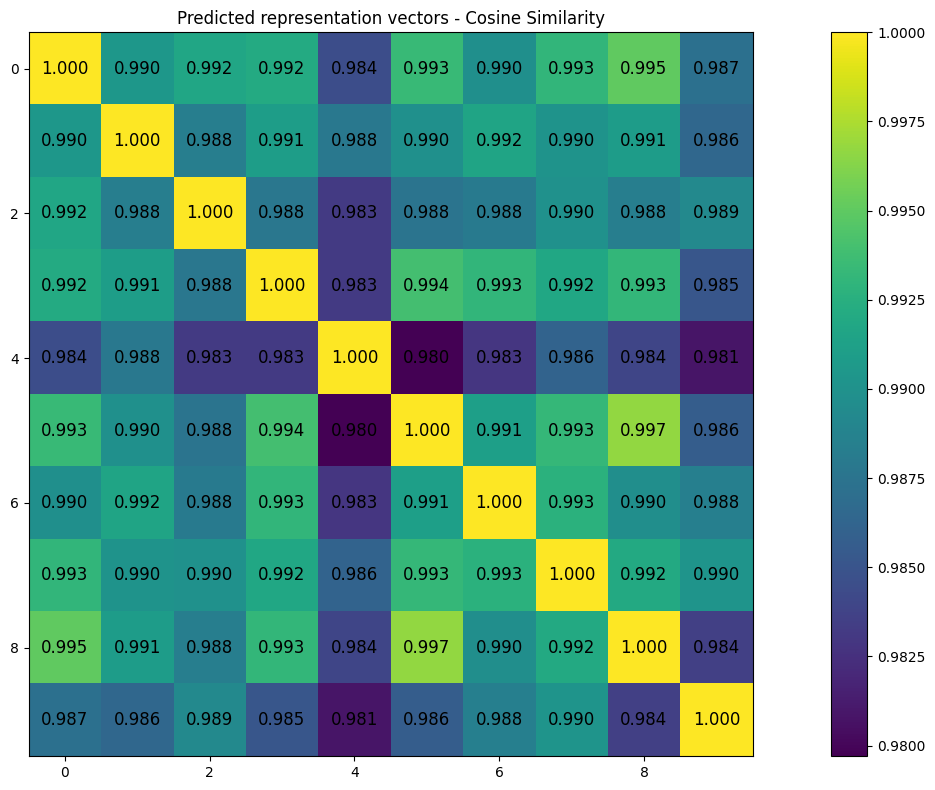

In [ ]:
# Visualization
plt.figure(figsize=(16, 8))
plt.imshow(cosine_sim_model, cmap='viridis')
plt.colorbar()
plt.title('Predicted representation vectors from model - Cosine Similarities')

for i in range(cosine_sim_model.shape[0]):
    for j in range(cosine_sim_model.shape[1]):
        plt.text(j, i, f"{cosine_sim_model[i, j]:.3f}",
                 ha='center', va='center', fontsize=12,
                 color='white' if cosine_sim_model[i, j] < 0.5 else 'black')

plt.tight_layout()
plt.show()

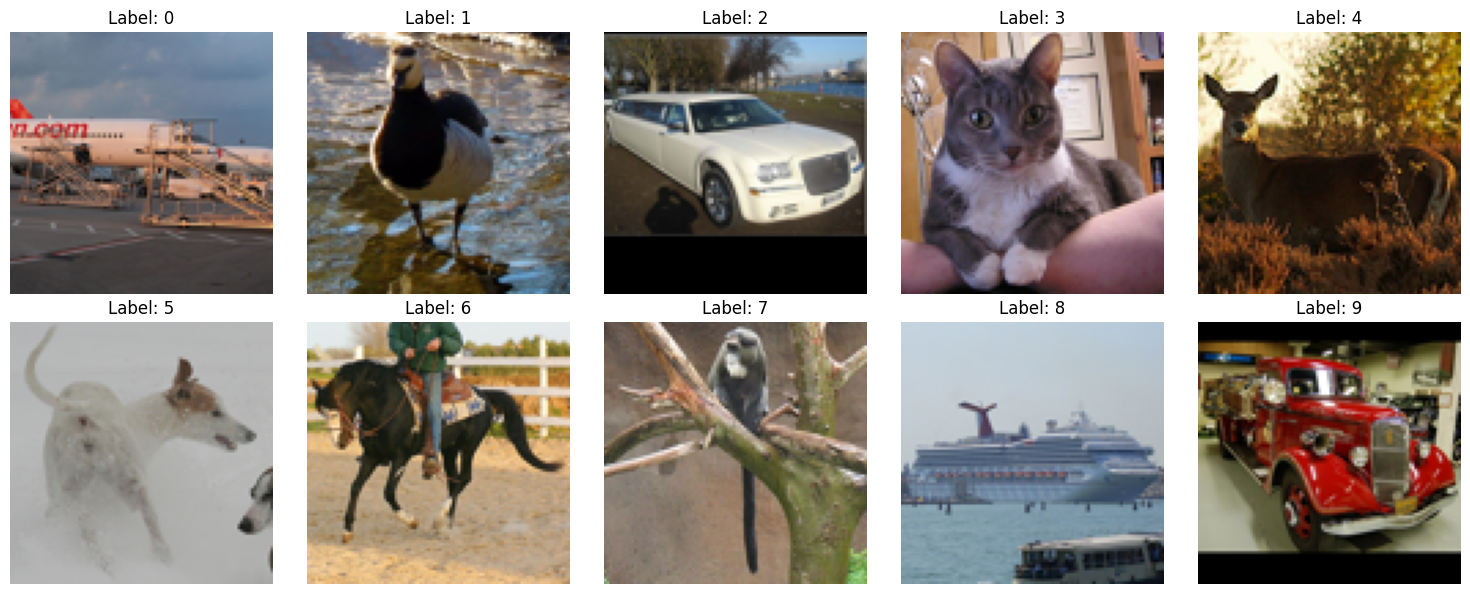

In [29]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()